# Heisenberg model with MPS DMRG
---

In [1]:
using ITensors
using PyPlot
using Statistics

include("custom_dmrg.jl")

HXXZ_dmrg_opt (generic function with 3 methods)

### ITensors Implementation

In [2]:
function HXXZ_dmrg_ready(N, Jxx, Jz)
    
  sites = siteinds("S=1/2",N)

  ampo = OpSum()
  for j=1:N-1
    ampo += Jxx*0.5,"S+",j,"S-",j+1
    ampo += Jxx*0.5,"S-",j,"S+",j+1
    ampo += Jz,"Sz",j,"Sz",j+1
  end
  H = MPO(ampo,sites)

  sweeps = Sweeps(5)
  maxdim!(sweeps,10,20,100,100,200)
  cutoff!(sweeps,1E-10)

  psi0 = randomMPS(sites,2)

  energy,psi = dmrg(H,psi0,sweeps)

  return energy, psi
end

HXXZ_dmrg_ready (generic function with 1 method)

In [ ]:
conv = []

for n in 100:100:2000
    E, psi = HXXZ_dmrg_ready(n,0.2,0.5)
    push!(conv, E/n)
end

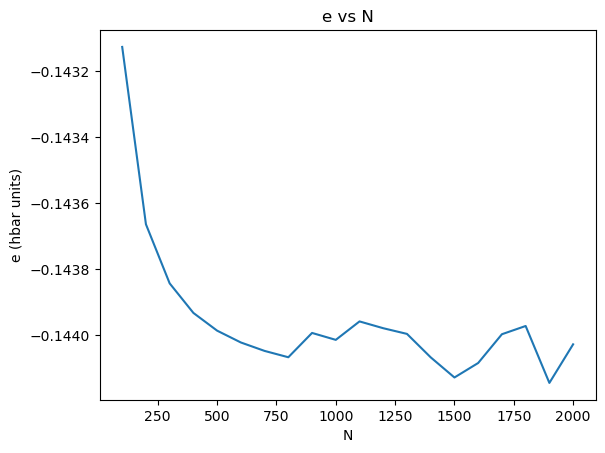

PyObject Text(24.0, 0.5, 'e (hbar units)')

In [11]:
plot(100:100:2000, conv);
title("e vs N")
xlabel("N")
ylabel("e (hbar units)")

In [ ]:
N = 100
Jxx = [-3.5,-2.0,-0.7,0.1,0.7,2.,3.5]
Deltas = [-3.0,-1.5,-0.8,0.1,0.8,1.5,3.0]

e = []
gr_st = []

for delta in Deltas
    for j in Jxx
        E, psi = HXXZ_dmrg_ready(N,j,delta*j)
        push!(e, E/N)
        push!(gr_st, psi)
    end
end


In [4]:
matrix = Matrix{Float64}(undef, length(Deltas), length(Jxx))
for i=1:length(Deltas)
    for j=1:length(Jxx)
        matrix[i,j] = e[(i-1)*length(Jxx)+j]
    end
end

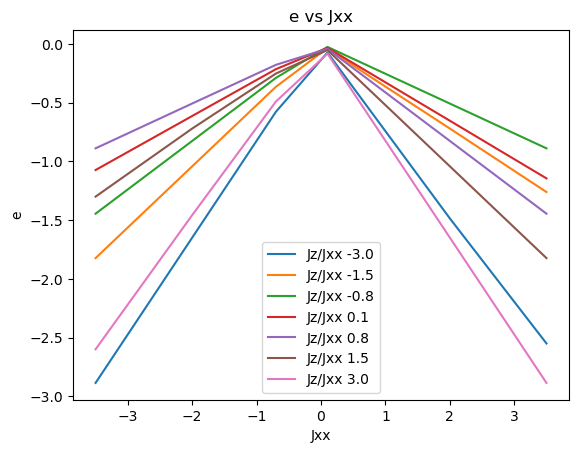

In [18]:
for j=1:length(Deltas)
    plot(Jxx, matrix[j,:], label="Jz/Jxx $(Deltas[j])");
    title("e vs Jxx")
    xlabel("Jxx")
    ylabel("e")
end
legend();

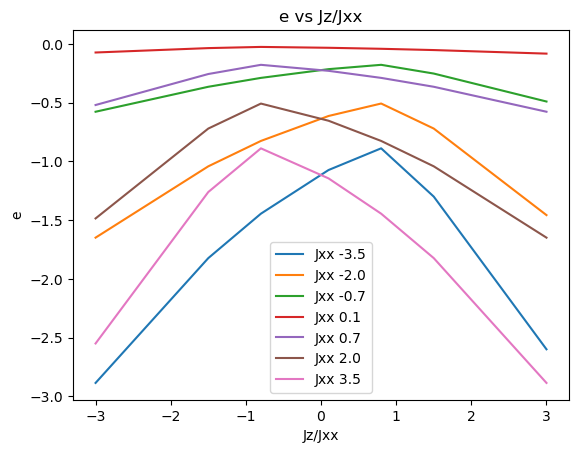

In [19]:
for j=1:length(Jxx)
    plot(Deltas, matrix[:,j], label="Jxx $(Jxx[j])");
    title("e vs Jz/Jxx")
    xlabel("Jz/Jxx")
    ylabel("e")
end
legend();

In [5]:
states = Matrix{MPS}(undef, length(Deltas), length(Jxx))
for i=1:length(Deltas)
    for j=1:length(Jxx)
        states[i,j] = gr_st[(i-1)*length(Jxx)+j]
    end
end

In [6]:
sz_m = Matrix{Vector{Float64}}(undef, length(Deltas), length(Jxx))
sx_m = Matrix{Vector{Float64}}(undef, length(Deltas), length(Jxx))
avg_sz = Matrix{Float64}(undef, length(Deltas), length(Jxx))
avg_sx = Matrix{Float64}(undef, length(Deltas), length(Jxx))

for i=1:length(Deltas)
    for j=1:length(Jxx)
        sz_m[i,j] = expect(states[i,j], "Sz")
        sx_m[i,j] = expect(states[i,j], "Sx")
        avg_sz[i,j] = mean(sz_m[i,j])
        avg_sx[i,j] = mean(sx_m[i,j])
    end
end


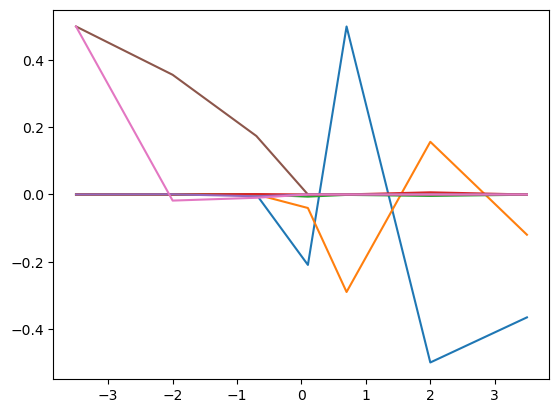

In [22]:
for j=1:length(Deltas)
    plot(Jxx, avg_sz[j,:]);
end

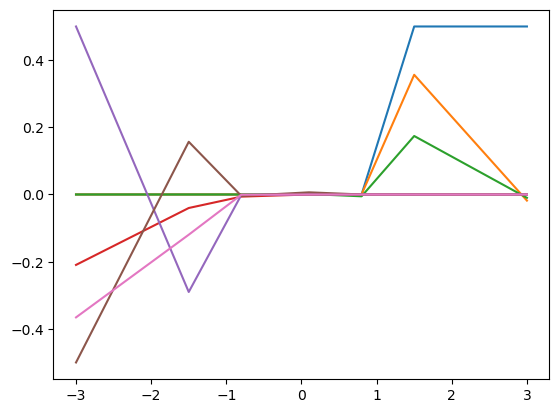

In [23]:
for j=1:length(Jxx)
    plot(Deltas, avg_sz[:,j]);
end

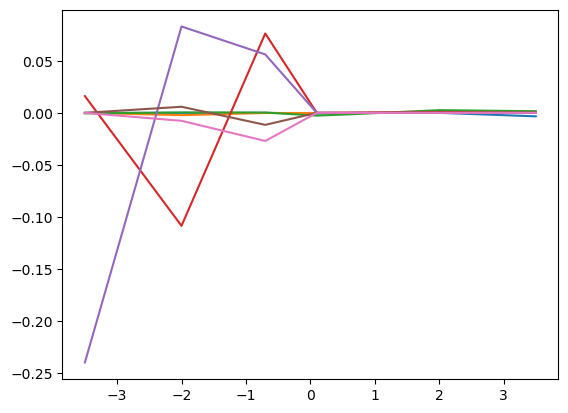

In [24]:
for j=1:length(Deltas)
    plot(Jxx, avg_sx[j,:]);
end

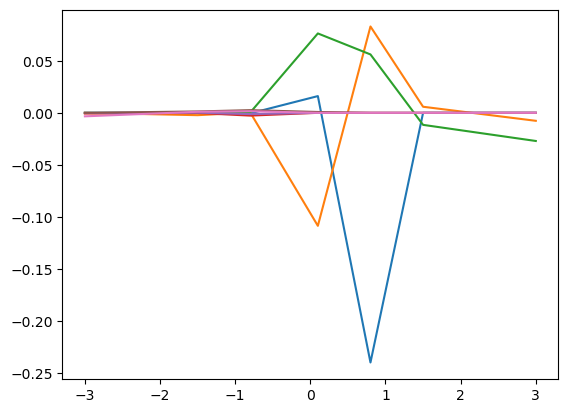

In [25]:
for j=1:length(Jxx)
    plot(Deltas, avg_sx[:,j]);
end

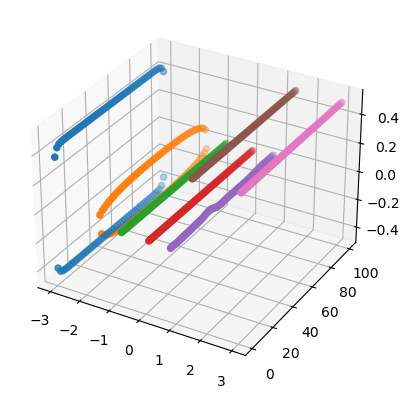

In [26]:
for i=1:length(Deltas)
    scatter3D([Deltas[i] for j=1:N], 1:N, sz_m[i,1])
end

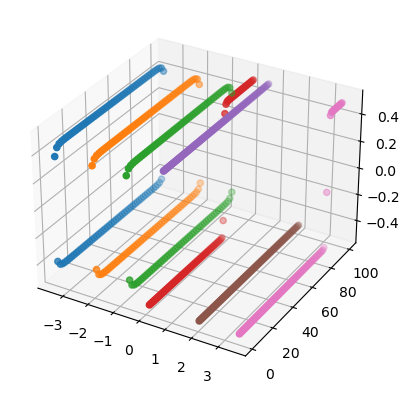

In [27]:
for i=1:length(Jxx)
    scatter3D([Jxx[i] for j=1:N], 1:N, sz_m[1,i]);
end

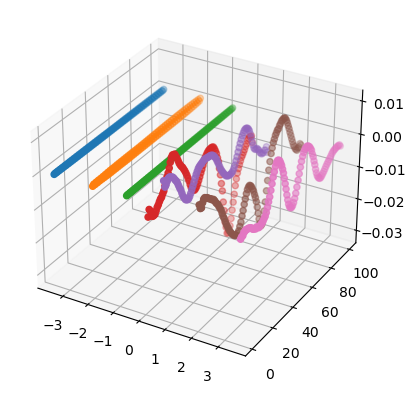

In [28]:
for i=1:length(Jxx)
    scatter3D([Jxx[i] for j=1:N], 1:N, sz_m[3,i]);
end

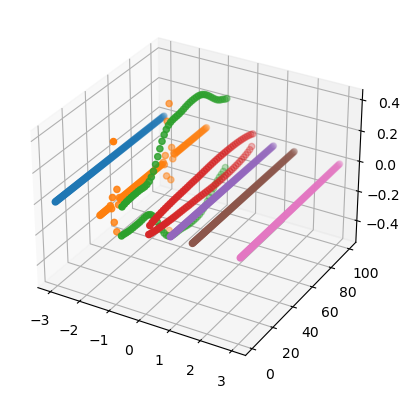

In [13]:
for i=1:length(Deltas)
    scatter3D([Deltas[i] for j=1:N], 1:N, sx_m[i,4])
end

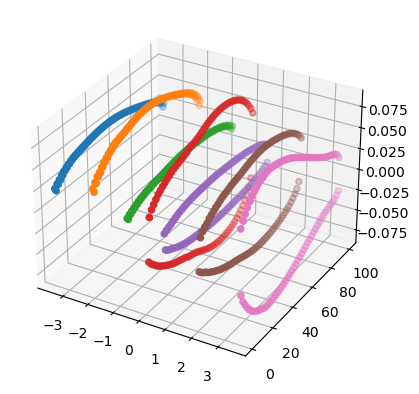

In [19]:
for i=1:length(Jxx)
    scatter3D([Jxx[i] for j=1:N], 1:N, sx_m[4,i]);
end

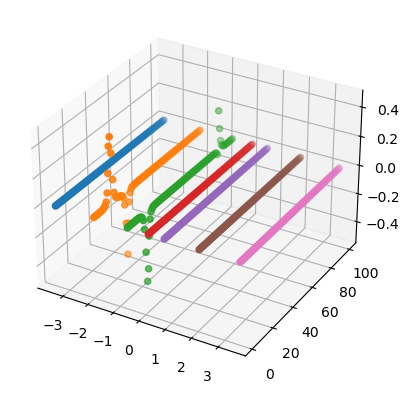

In [31]:
for i=1:length(Jxx)
    scatter3D([Jxx[i] for j=1:N], 1:N, sx_m[6,i]);
end

In [32]:
zz_cor = Matrix{Any}(undef, length(Deltas), length(Jxx))
for i=1:length(Deltas)
    for j=1:length(Jxx)
        zz_cor[i,j] = correlation_matrix(states[i,j],"Sz","Sz")
    end
end

In [33]:
avg_cor = Matrix{Float64}(undef, length(Deltas), length(Jxx))
for i=1:length(Deltas)
    for j=1:length(Jxx)
        sum = 0
        for k=1:N
            for l=k+1:N
                sum += zz_cor[i,j][k,l]
            end
        end
        sum = sum/(N^2/2-N/2)
        avg_cor[i,j] = sum
    end
end

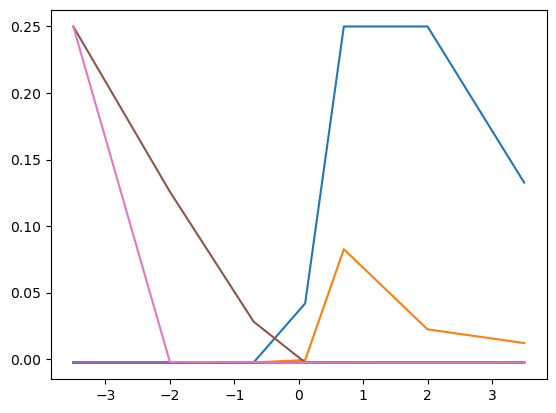

In [34]:
for j=1:length(Deltas)
    plot(Jxx, avg_cor[j,:]);
end

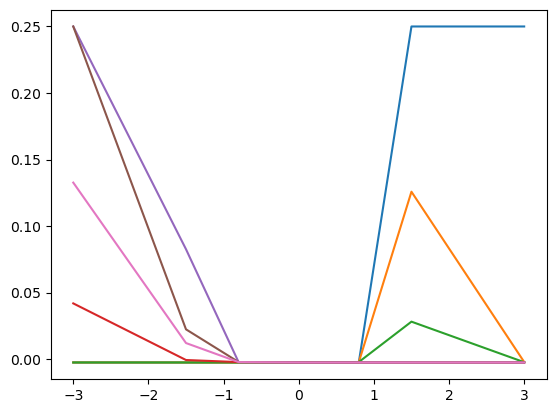

In [35]:
for j=1:length(Jxx)
    plot(Deltas, avg_cor[:,j]);
end

In [36]:
cor_dist = Matrix{Any}(undef, length(Deltas), length(Jxx))
for i=1:length(Deltas)
    for j=1:length(Jxx)
        dist = []
        corr = []
        for k=1:N
            for l=k+1:N
                push!(dist, abs(k-l))
                push!(corr, zz_cor[i,j][k,l])
            end
        end
        cor_dist[i,j] = [dist, corr]
    end
end

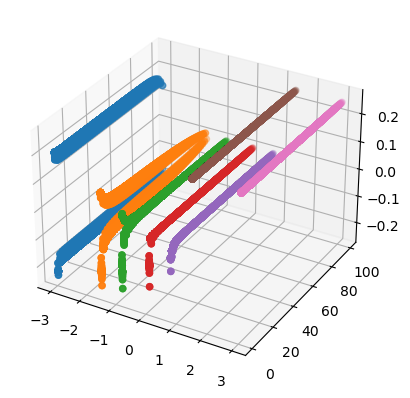

In [37]:
len = length(cor_dist[1,1][1])

for i=1:length(Deltas)
    scatter3D([Deltas[i] for j=1:len], cor_dist[i,1][1], cor_dist[i,1][2])
end

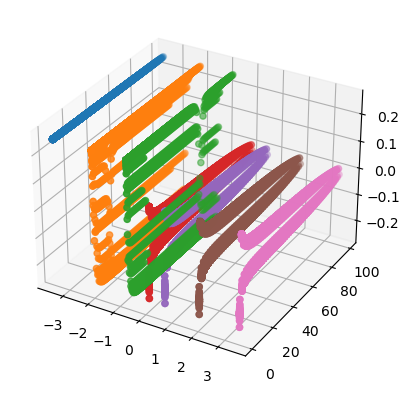

In [38]:
len = length(cor_dist[1,1][1])

for i=1:length(Jxx)
    scatter3D([Jxx[i] for j=1:len], cor_dist[6,i][1], cor_dist[6,i][2])
end

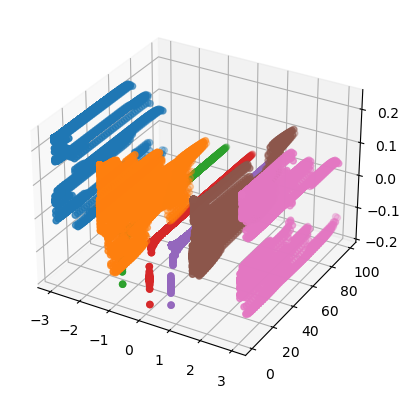

In [39]:
len = length(cor_dist[1,1][1])

mean_j = []
for i=1:length(Deltas)
    dist = [0 for k=1:len]
    corr = [0 for k=1:len]
    for j=1:length(Jxx)
        dist += cor_dist[i,j][1]
        corr += cor_dist[i,j][2]
    end
    push!(mean_j, [dist/length(Jxx), corr/length(Jxx)])
end

for i=1:length(Deltas)
    scatter3D([Deltas[i] for j=1:len], mean_j[i][1], mean_j[i][2])
end

---
### Implementation with basic tensors

In [40]:
HXXZ_dmrg(6, 2.5, 3.6, 10, 4) # N, Jxx, Jz, sweeps, bond dimension

energy sweep 1: 8.976776007860233
energy sweep 2: 8.999682305185253
energy sweep 3: 8.99992166563555
energy sweep 4: 8.999989647183526
energy sweep 5: 8.999998657059308
energy sweep 6: 8.999999825947498
energy sweep 7: 8.999999977442755
energy sweep 8: 8.99999999707658
energy sweep 9: 8.999999999621135
energy sweep 10: 8.999999999950903


8.999999999950903

In [41]:
HXXZ_dmrg_opt(6, 2.5, 3.6, 10, 4)

energy sweep 1: -7.151350262541915
energy sweep 2: -10.32479530204522
energy sweep 3: -10.705316571338455
energy sweep 4: -10.781047645378294
energy sweep 5: -10.796244567468966
energy sweep 6: -10.7992577131916
energy sweep 7: -10.799853356895166
energy sweep 8: -10.799971032736334
energy sweep 9: -10.799994278043114
energy sweep 10: -10.7999988697358


-10.7999988697358